# Baseline without RAG.

Import packages.

In [1]:
import os
import pandas as pd

from datetime import datetime
from dotenv import load_dotenv
from json import loads, dumps
from langchain.tools import tool
# from langchain.tools.retriever import create_retriever_tool

from pydantic import BaseModel, Field
from typing import Annotated, Sequence, TypedDict, Literal

from IPython.display import Image, display

# from langchain_chroma import Chroma
# from langchain_community.document_loaders import PyPDFLoader

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from langchain_openai import OpenAIEmbeddings, ChatOpenAI
# from langchain_text_splitters import RecursiveCharacterTextSplitter

from langfuse import Langfuse, get_client
from langfuse.langchain import CallbackHandler
from langfuse.openai import openai  # Don't delete this line.

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode

Set up environment variables.

In [2]:
# Set up environment variables.
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')

# Monitor if the environment variables are ready.
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set - please head to the troubleshooting guide in the setup folder")

OpenAI API Key exists and begins sk-proj-


In [3]:
langfuse_secret_key = os.getenv('LANGFUSE_SECRET_KEY')
langfuse_public_key = os.getenv('LANGFUSE_PUBLIC_KEY')
langfuse = Langfuse(
    secret_key = langfuse_secret_key,
    public_key = langfuse_public_key,
    host="https://cloud.langfuse.com"
    # host = "https://us.cloud.langfuse.com"
)

langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


Define supporting variables and functions.

In [4]:
CONFIG = {
    # "vector_store_directory": "./chroma_db",
    # "vector_store_collection_name": "langchain_rag",
    # "chunk_size": 500,
    # "chunk_overlap": 50
}

In [5]:
def format_job_descriptions(jd_dataframe):
    if isinstance(jd_dataframe, pd.Series):
        jd_dataframe = jd_dataframe.to_frame().T
    result = jd_dataframe.to_json(orient='records')
    return result

Function test.

In [7]:
df = pd.read_csv("data/X_test.csv")
test = df.iloc[0, :]
if isinstance(test, pd.Series):
        test = test.to_frame().T
json_records = test.to_json(orient='records')
parsed = loads(json_records)
print(dumps(parsed, indent=4) )

[
    {
        "title": "Driver / Tour Guide for Coach & 4WD Coach Tours",
        "abstract": "This role includes conducting 1-20 Day Tours to a range of locations all over Australia with mature passengers for a well established family company.",
        "job_description_clean": "Casey Australia Tours require a experienced Coach Drivers / Tour Guide for the rest of the 2019 season of extended motel and/or camping tours starting mid/late June The role requires driving, minor coach maintenance, cleaning, guiding and commentating plus some cooking. The ideal person should have; 1. A sense of humour and engaging personality 2. Initiative and problem solving skills 3. Confidence and be a good public speaker 4. A current manual HR drivers licence with F endorsement. (or ability to get one quickly) 5. A safe driving record 6. Clear Criminal History 7. Experience in some field that can be related 8. First Aid Training 9. Good Navigation in remote and city areas Handy assets to have; 1. Mecha

In [8]:
@tool
def check_basic_information(job_descriptions) -> dict:
    """
    This function consumes job_descriptions and return basic information with good formatted strings.
    """
    if isinstance(job_descriptions, pd.Series):
        job_descriptions = job_descriptions.to_frame().T

    list_of_dicts = job_descriptions.to_dict(orient='records')
    
    jobs_info = []
    for i, job_dict in enumerate(list_of_dicts):
        jobs_info.append({
            "job_index": i,
            "fields": job_dict
        })

    result = {
        "summary": "The information of each job advertisement is as follows.",
        "jobs": jobs_info
    }

    return result

tools = [check_basic_information]

Define Graph Sate.

In [9]:
class AgentState(TypedDict):
    """
    Represents the state of graph.

    Attributes:
        messages: A list of messages in the conversation, including user input and agent outputs.

    Notes:
        The add_messages function defines how an update should be processed.
        Default is to replace. add_messages says "append".
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

Deinfe Basic Nodes.

Input: job description strings.

Host node

Conditional Edge: whether the question is about to check job descriptions.

If not, return generate.

If yes, go to next node.

Get industry information and professional skills.

Get general requirements.

Evaluate the job advertisement.

Refine the job advertisement.



In [10]:
def host_agent(state):
    """
    Invokes the whole workflow and monitor the state.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    
    print("---CALL HOST AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    response = model.invoke(messages)
    
    return {"messages": [response]}

In [ ]:
def industry_agent(state, job_ads):
    """
    Generate answer. The core of RAG.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---CALL INDUSTRY AGENT---")
    messages = state["messages"]

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a helpful assistant that extracts structured information from a batch of job advertisements.

            Input job ad:
            {job_text}

            Instruction:
            Extract the following fields from the given batch of different job ads. If a field is not present, return an empty list for that field.

            - skills: short list of skills, tools, technologies (e.g., "Python", "SQL", "scikit-learn", "communication")
            - responsibilities: short concise list of responsibilities / duties described in the ad
            - requirements: candidate requirements such as experience, qualifications, degrees, certifications, years of experience

            Return a list of JSON objects ONLY with keys: "job_titles", "skills", "responsibilities", "requirements". 

            Example:
            {
            {"job_title": ["Data Scientist"], "skills": ["Python", "SQL"], "responsibilities": ["build predictive models"], "requirements": ["3+ years experience", "Bachelor's degree"]}
            {"job_title": ["Primary Teacher"], "skills": ["Education", "Child Care"], "responsibilities": ["Give courses"], "requirements": ["5+ years experience", "Master's degree"]}
            }
        """,
        input_variables=["job_text"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0, streaming=True)

    # Chain
    chain = prompt | llm | StrOutputParser()

    # Run
    response = chain.invoke({"job_text": job_ads})
    print(response)
    return {"messages": [response]}

Define conditional edge.

In [12]:
# Conditional Edge: whether the question is about to check job descriptions.

def check_task_agent(state, config) -> Literal["industry_agent", "host_agent"]:
    """
    Determines whether the question is about to check job descriptions.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the question is about to check job descriptions.
    """

    print("---CHECK TASK RELEVANCE---")

    # Pydantic to ensure the output format.
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Task relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a grader assessing relevance of user's question and job advertisement analysis task. \n 
            Here is the user question: {question} \n
            If the question contains keyword(s) or semantic meaning related to job advertisement analysis, grade it as relevant. \n
            Give a binary score 'yes' or 'no' score to indicate whether the user question is relevant to job advertisement analysis.
        """,
        input_variables=["question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    
    question = config["configurable"]["questions"][-1]
    print("User question:\n", question)
    

    scored_result = chain.invoke({"question": question})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: This is a job advertisement analysis task. ---")
        return "industry_agent"

    else:
        print("---DECISION: This is not a job advertisement analysis task.---")
        return "host_agent"

Complie the graph.

In [19]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes.
# workflow.add_node("host_agent", host_agent)  
workflow.add_node("industry_agent", industry_agent)  

# Call agent node to decide to retrieve or not
# workflow.add_edge(START, "host_agent")

workflow.add_edge(START, "industry_agent")

# Decide whether to retrieve
# workflow.add_conditional_edges(
#     "host_agent",
#     check_task_agent,
# )
# workflow.add_edge("host_agent", "industry_agent")
workflow.add_edge("industry_agent", END)

# Compile
graph = workflow.compile(checkpointer=MemorySaver())


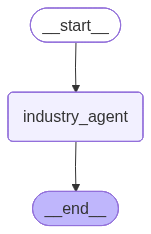

In [20]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [15]:
def agent_invoke(graph, question, config):
    """
    Invoke the workflow with user question, generate human-friendly metrics and answers.

    Args:
        graph: The current workflow
        question: The user input to invoke the workflow
        config: The holder of thread, memory, and LangFuse

    Returns:
        retriever_counter: how many times the retriever tool is called for this question
        rewrite_counter: how many times the question is rewritten, which indicates a failed retrieval
        final_message: the answer that can be shown to all audience
    """
    config["configurable"]["questions"].append(question)
    print("config", config)

    final_message = ""

    inputs = {
        "messages":[
            ("user", question)
        ]
    }

    for output in graph.stream(inputs, config=config):
        for key, value in output.items():
            # For Agent node, output tool call information.
            if key == 'host_agent':
                final_message = final_message + value['messages'][0].content
                print(final_message)
            # For retrieve tool node, counter plus.
            elif key == 'industry_agent':
                final_messsage = final_message + value['messages'][0]
                print(final_message)
                print("\n---END QUESTION---")
            else:
                pass
            print(final_message)
    return final_message

In [16]:
def deal_with_single_question(logs, graph, question, config):
    """
    Deal with the workflow inputs and outputs, push them into local logging system.

    Args:
        logs: the list to store key information and metrics for the whole thread
        graph: The current workflow
        question: The user input to invoke the workflow
        config: The holder of thread, memory, and LangFuse
    """
    # Get the current date and time for time stamp.
    invoke_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
    final_message = agent_invoke(graph, question, config)
    thread_id = config['configurable']['thread_id']
    row =  [thread_id, invoke_datetime, question, final_message]
    logs.append(row)

In [17]:
config = {"configurable": {"thread_id": "0", "questions": []}}
logs = []

In [ ]:
df = pd.read_csv("data/X_test.csv")
test = df.iloc[0, :]
if isinstance(test, pd.Series):
        test = test.to_frame().T
json_records = test.to_json(orient='records')
parsed = loads(json_records)
print(dumps(parsed, indent=4) )

In [18]:
deal_with_single_question(logs, graph, "Hi, I'm Alexandra. Please help me analyse following job advertisements", config)

config {'configurable': {'thread_id': '0', 'questions': ["Hi, I'm Alexandra. Please help me analyse following job advertisements"]}}
---CALL HOST AGENT---
Hello Alexandra! I'd be happy to help you analyze the job advertisements you have. Please provide the details of the job advertisements you'd like to discuss, and let me know what specific aspects you want to focus on (e.g., job requirements, qualifications, company culture, etc.).
Hello Alexandra! I'd be happy to help you analyze the job advertisements you have. Please provide the details of the job advertisements you'd like to discuss, and let me know what specific aspects you want to focus on (e.g., job requirements, qualifications, company culture, etc.).


TypeError: industry_agent() missing 1 required positional argument: 'job_ads'